In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pickle
import nltk
import os
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from framefinder import framedimensions
from framefinder import framelabels
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]
base_model = "all-mpnet-base-v2"

candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)
framing_dimensions = framedimensions.FramingDimensions(
    base_model, dimensions, pole_names
)

In [2]:
def visualize(align_scores_df, var):
    name_left = align_scores_df.columns.map(lambda x: x[1])
    name_right = align_scores_df.columns.map(lambda x: x[0])
    bias = align_scores_df.mean()
    color = ["b" if x > 0 else "r" for x in bias]
    inten = (var.fillna(0) + 0.001) * 50_000
    bounds = bias.abs().max() * 1.1

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.scatter(x=bias, y=name_left, s=inten, c=color)
    plt.axvline(0)
    plt.xlim(-bounds, bounds)
    plt.gca().invert_yaxis()
    axi = ax.twinx()
    axi.set_ylim(ax.get_ylim())
    axi.set_yticks(ax.get_yticks(), labels=name_right)
    plt.tight_layout()
    return fig


def find_min_max_values(directory):
    # Mean
    all_values = []
    variance = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path, header=[0, 1])
                means = df.mean().values
                all_values.extend(means)
                variance.extend(df.var().values)
    min_v = min(all_values)
    max_v = max(all_values)
    min_var = min(variance)
    max_var = max(variance)
    return min_v - 1 / 20 * min_v, max_v + 1 / 20 * max_v, min_var, max_var


def normalize_files(input_dir, output_dir, output_dir_var, create_plots, plt_directory):
    min_v, max_v, min_var, max_var = find_min_max_values(input_dir)
    if max_v > abs(min_v):
        min_v = -max_v
    else:
        max_v = abs(min_v)
    os.makedirs(output_dir, exist_ok=True)

    for file in os.listdir(input_dir):
        if file.endswith(".csv"):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(
                output_dir, f"{os.path.splitext(file)[0]}_norm.csv"
            )
            output_path_dir = os.path.join(
                output_dir_var, f"{os.path.splitext(file)[0]}_norm.csv"
            )
            df = pd.read_csv(input_path, header=[0, 1])
            means = df.mean().values
            normalized_means = [
                2 * ((xi - min_v) / (max_v - min_v)) - 1 for xi in means
            ]
            variance_df = pd.DataFrame(df.var()).T
            norm_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(pole_names))
            norm_df.loc[0] = normalized_means
            var_norm_df = pd.concat([variance_df, norm_df], ignore_index=True)

            norm_df.to_csv(output_path, index=False)
            var_norm_df.to_csv(output_path_dir, index=False)
            if create_plots:
                g = visualize(norm_df, df.var())
                g.axes[0].set_axisbelow(True)
                g.axes[0].yaxis.grid(color="gray", linestyle="dashed")
                plt.title(
                    'Normalized Frame Dimensions for "' + os.path.splitext(file)[0]
                )
                plt.gcf().set_size_inches(10, 7)
                plt.xlim(-1, 1)
                plt.savefig(
                    plt_directory + "_" + os.path.splitext(file)[0],
                    bbox_inches="tight",
                )
                plt.close()

	Comparing custom: 
		- Press over Time


/tmp/ipykernel_209606/900612886.py:70: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=means[0], y=name_left, s=size_first, c=colors[0])
/tmp/ipykernel_209606/900612886.py:82: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=means[i], y=name_left, s=intens[i], c=colors[i])
/tmp/ipykernel_209606/900612886.py:80: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be 

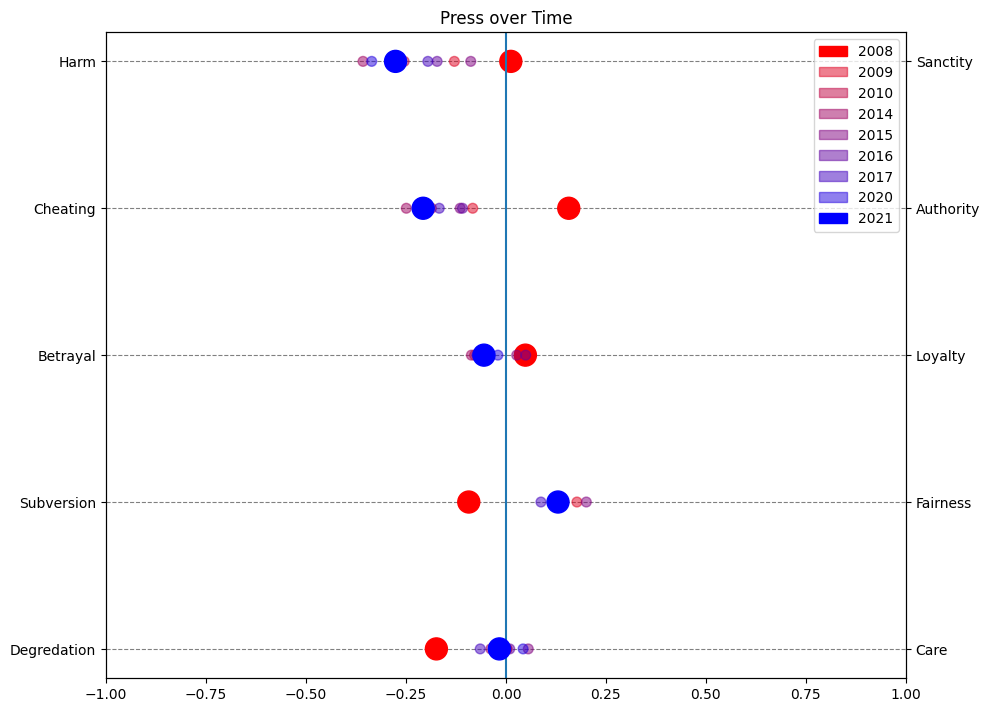

In [4]:
def create_custom_color_list(num_years):
    blue = mcolors.to_rgba("blue", alpha=1.0)
    red = mcolors.to_rgba("red", alpha=1.0)

    colors = []
    for i in range(num_years):
        if i == 0:
            blended_color = red
        elif i == num_years - 1:
            blended_color = blue
        else:
            opacity = 1.0 - i / (num_years - 1)
            blended_color = tuple(
                (1 - opacity) * b + opacity * r for b, r in zip(blue, red)
            )
            blended_color = blended_color[:3] + (0.5,)
        colors.append(blended_color)

    return colors


def compare_plots(
    dfs, titles, colors=None, fade=True, save=False, compare=None, var=True
):
    if colors is None:
        if fade:
            colors = create_custom_color_list(len(titles))
        else:
            if len(dfs) > 10:
                colors = sns.color_palette("husl", len(titles))
            else:
                colors = list(mcolors.TABLEAU_COLORS)
    var_dfs = []
    data_dfs = []
    if var:
        for df in dfs:
            var_df = df.iloc[0:1]
            data_df = df.iloc[1:2]
            var_dfs.append(var_df)
            data_dfs.append(data_df)

    name_left = dfs[0].columns.map(lambda x: x[1])
    name_right = dfs[0].columns.map(lambda x: x[0])

    if var:
        means = [df.mean() for df in data_dfs]
        intens = [(df.fillna(0) + 0.001) * 50_000 for df in var_dfs]
    else:
        means = [df.mean() for df in dfs]
        intens = [(df.var().fillna(0) + 0.001) * 50_000 for df in dfs]

    if save:
        path = "dumps/df_dumps/grouped_by_name/grouped_by_" + compare + ".csv"
        dfs[0].to_csv(path, index=False)
        for df in dfs[1:]:
            df.to_csv(path, index=False, header=False, mode="a")

    legend_entries = [mpatches.Patch(color=colors[0], label=titles[0])]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Specify sizes for first and last dots
    size_first = intens[0]
    size_last = intens[-1]
    if fade:
        size_first = intens[0] * 5  # Increase size for the first dot
        size_last = intens[-1] * 5  # Increase size for the last dot

    plt.scatter(x=means[0], y=name_left, s=size_first, c=colors[0])
    plt.axvline(0)
    plt.gca().invert_yaxis()
    ax.twinx().set_yticks(ax.get_yticks(), labels=name_right)
    fig.axes[0].set_axisbelow(True)
    fig.axes[0].yaxis.grid(color="gray", linestyle="dashed")
    plt.xlim(-1, 1)  # ! arbitrary range

    for i in range(1, len(dfs)):
        if i == len(dfs) - 1:  # For the last dot
            plt.scatter(x=means[i], y=name_left, s=size_last, c=colors[i])
        else:
            plt.scatter(x=means[i], y=name_left, s=intens[i], c=colors[i])
        legend_entries.append(mpatches.Patch(color=colors[i], label=titles[i]))

    plt.gcf().set_size_inches(10, 7)
    plt.tight_layout()
    plt.legend(handles=legend_entries)
    return fig


def compareCustom(
    save_path, df_paths, custom_names=None, title=None, fade=True, var=True
):
    print(f"\tComparing custom: ")
    dfs = []
    names = []
    for path in df_paths:
        dfs.append(pd.read_csv(path, header=[0, 1]))
        names.append(os.path.splitext(os.path.basename(path))[0])
    if custom_names is not None:
        names = custom_names
    if title is None:
        title = f"Comparing {names[0]}"
        for name in names[1:]:
            title += f" and {name}"
    g = compare_plots(dfs, names, fade=fade, var=var)
    plt.title(title)
    print(f"\t\t- " + str(title))
    plt.savefig(
        save_path + title + ".png",
        bbox_inches="tight",
    )


paths = [
    "COP/dumps/dimensions_normalized/Presse_2008_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2009_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2010_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2014_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2015_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2016_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2017_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2020_dimensions_norm.csv",
    "COP/dumps/dimensions_normalized/Presse_2021_dimensions_norm.csv",
]

custom_names = ["2008", "2009", "2010", "2014", "2015", "2016", "2017", "2020", "2021"]
compareCustom(
    "COP/plots/custom_compare_frame/",
    paths,
    custom_names=custom_names,
    title="Press over Time",
    fade=True,
    var=False,
)

<Figure size 800x600 with 0 Axes>

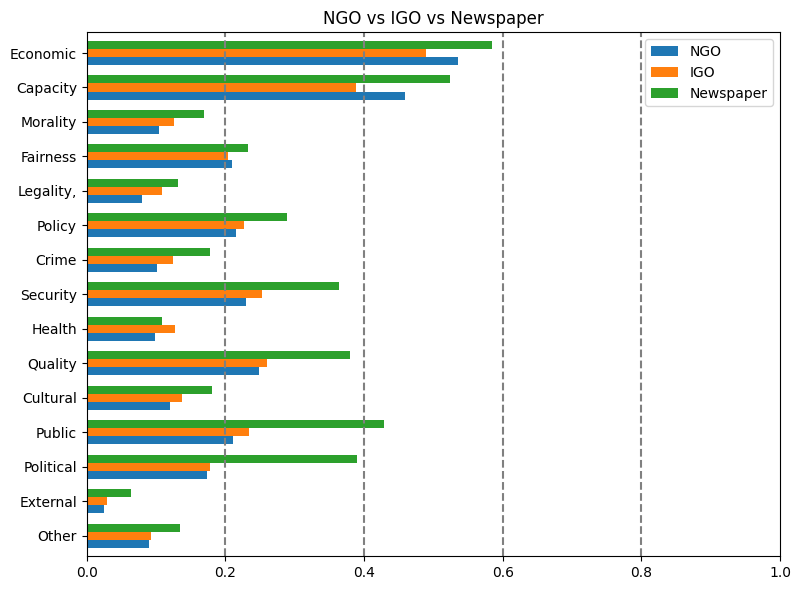

In [6]:
def process_label_files(file_paths, custom_names, output_dir):
    if not file_paths:
        print("No file paths provided")
        return

    os.makedirs(output_dir, exist_ok=True)

    df_list = []
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df_mean = df.mean().to_frame(name=file_path)
        df_mean.index.name = "Name"
        df_list.append(df_mean)

    merged_df = df_list[0]
    for elm in df_list[1:]:
        merged_df = pd.merge(merged_df, elm, on="Name")

    return merged_df


# Usage example
file_paths = [
    "COP/dumps/labels/NGO.csv",
    "COP/dumps/labels/IGO.csv",
    "COP/dumps/labels/Newspapers.csv",
]

custom_names = [
    "NGO",
    "IGO",
    "Newspaper",
]

output_dir = "COP/plots/custom_compare_label/"
name = "NGO vs IGO vs Newspaper"
combined_df = process_label_files(file_paths, custom_names, output_dir)
if combined_df is not None:
    merged_df = combined_df.iloc[::-1]
    merged_df.columns = custom_names
    plt.figure(figsize=(8, 6))
    merged_df.plot(kind="barh", figsize=(8, 6), width=0.7)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(name)
    plt.legend(custom_names)
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.xlim(0, 1)
    for x in [0.2, 0.4, 0.6, 0.8]:
        plt.axvline(x=x, color="grey", linestyle="--")
    plt.savefig(
        os.path.join(output_dir, name),
        bbox_inches="tight",
    )
    plt.show()
    plt.close()